In [28]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image, ImageStat, ImageEnhance

In [29]:
# read image paths into lists
# can iterate over lists to open images later

def read_img_dataset_paths(data_dir = 'images/asl_alphabet_train/'):
    img_paths = []

    for (dirpath, dirnames, filenames) in os.walk(data_dir):
        dirnames.sort()
        img_paths.extend([os.path.join(dirpath, f) for f in sorted(filenames)])

    return img_paths


In [37]:
train = read_img_dataset_paths('images/original/asl_alphabet_train/')
test = read_img_dataset_paths('images/original/asl_alphabet_test/')
print(f'Train dataset len: {len(train)} = \n\t{train[:5]}...')
print(f'Test dataset len: {len(test)} = \n\t{test[:5]}...')

Train dataset len: 87000 = 
	['images/original/asl_alphabet_train/A/A1.jpg', 'images/original/asl_alphabet_train/A/A10.jpg', 'images/original/asl_alphabet_train/A/A100.jpg', 'images/original/asl_alphabet_train/A/A1000.jpg', 'images/original/asl_alphabet_train/A/A1001.jpg']...
Test dataset len: 28 = 
	['images/original/asl_alphabet_test/A_test.jpg', 'images/original/asl_alphabet_test/B_test.jpg', 'images/original/asl_alphabet_test/C_test.jpg', 'images/original/asl_alphabet_test/D_test.jpg', 'images/original/asl_alphabet_test/E_test.jpg']...


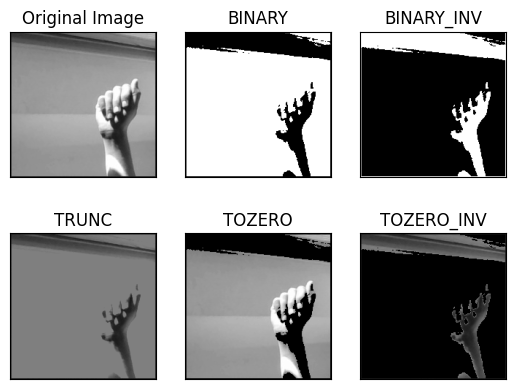

In [38]:
# test some thresholding

img = cv.imread('images/original/asl_alphabet_train/A/A1000.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
ret,thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
ret,thresh2 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
ret,thresh3 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
ret,thresh4 = cv.threshold(img,127,255,cv.THRESH_TOZERO)
ret,thresh5 = cv.threshold(img,127,255,cv.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

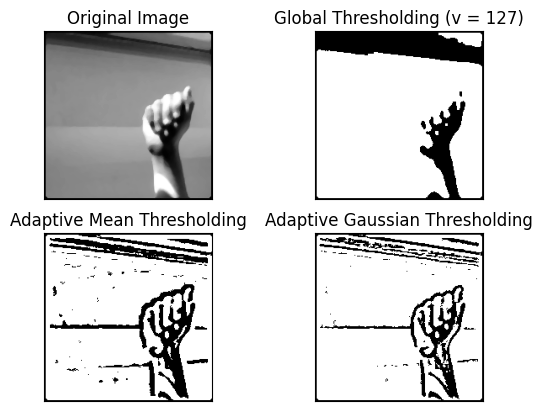

In [32]:
# test some other thresholding 

img = cv.imread('images/original/asl_alphabet_train/A/A1000.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

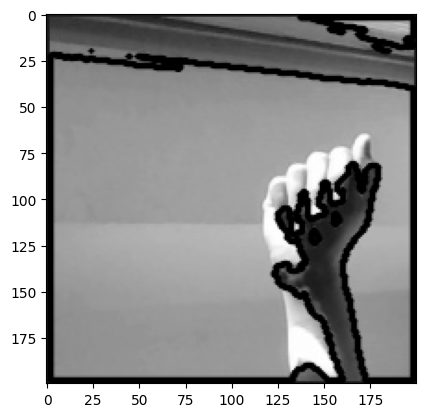

In [39]:
img = cv.imread('images/original/asl_alphabet_train/A/A1000.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
ret,thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY)

# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv.findContours(thresh1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
                                      
# draw contours on the original image
image_copy = img.copy()
cv.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
                
# see the results
plt.imshow(image_copy,'gray')
cv.waitKey(0)
cv.destroyAllWindows()

In [40]:
def downsample_imgs(train_img_paths):
    for i, path in enumerate(train_img_paths):
        image = Image.open(path)
        if i % 10 == 0:
            og_path = path.split('/')
            new_dir = f"images/sampled/asl_alphabet_train/{og_path[-2]}"
            os.makedirs(new_dir, exist_ok=True)
            enhancer = ImageEnhance.Sharpness(image)
            image = enhancer.enhance(4) 

            # Improve contrast
            enhancer = ImageEnhance.Contrast(image)
            image = enhancer.enhance(2)

            image = image.convert('L')

            image.save(f"{new_dir}/{og_path[-1]}")
            image.close()

downsample_imgs(train)

In [41]:
from PIL import Image, ImageStat

# update with more EDA stuff...
def train_img_stats(train_img_paths):
    headers = ['path', 'class', 'width', 'height', 'avg_brightness']
    data = []

    for i in train_img_paths:
        image = Image.open(i)

        # get average pixel brightness + possibly other image stats by converting to greyscale first
        stats = ImageStat.Stat(image.convert('L'))
        avg_brightness = stats.mean[0]
        data.append([i, i.split('/')[-2], image.width, image.height, avg_brightness]) # classes = 'A', 'B', 'C'...
        image.close()

    df = pd.DataFrame(data, columns=headers)

    return df

In [44]:
#train_df = train_img_stats(train)
#train_df.to_csv("train_img_stats.csv")

In [45]:
train_df = pd.read_csv("train_img_stats.csv")
train_df

,Unnamed: 0,path,class,width,height,avg_brightness
0,0,images/original/asl_alphabet_train/A/A1.jpg,A,200,200,113.822725
1,1,images/original/asl_alphabet_train/A/A10.jpg,A,200,200,113.820850
2,2,images/original/asl_alphabet_train/A/A100.jpg,A,200,200,105.395600
3,3,images/original/asl_alphabet_train/A/A1000.jpg,A,200,200,141.781600
4,4,images/original/asl_alphabet_train/A/A1001.jpg,A,200,200,141.954150
...,...,...,...,...,...,...
86995,86995,images/original/asl_alphabet_train/space/space...,space,200,200,135.161425
86996,86996,images/original/asl_alphabet_train/space/space...,space,200,200,135.601250
86997,86997,images/original/asl_alphabet_train/space/space...,space,200,200,136.007250
86998,86998,images/original/asl_alphabet_train/space/space...,space,200,200,136.229325


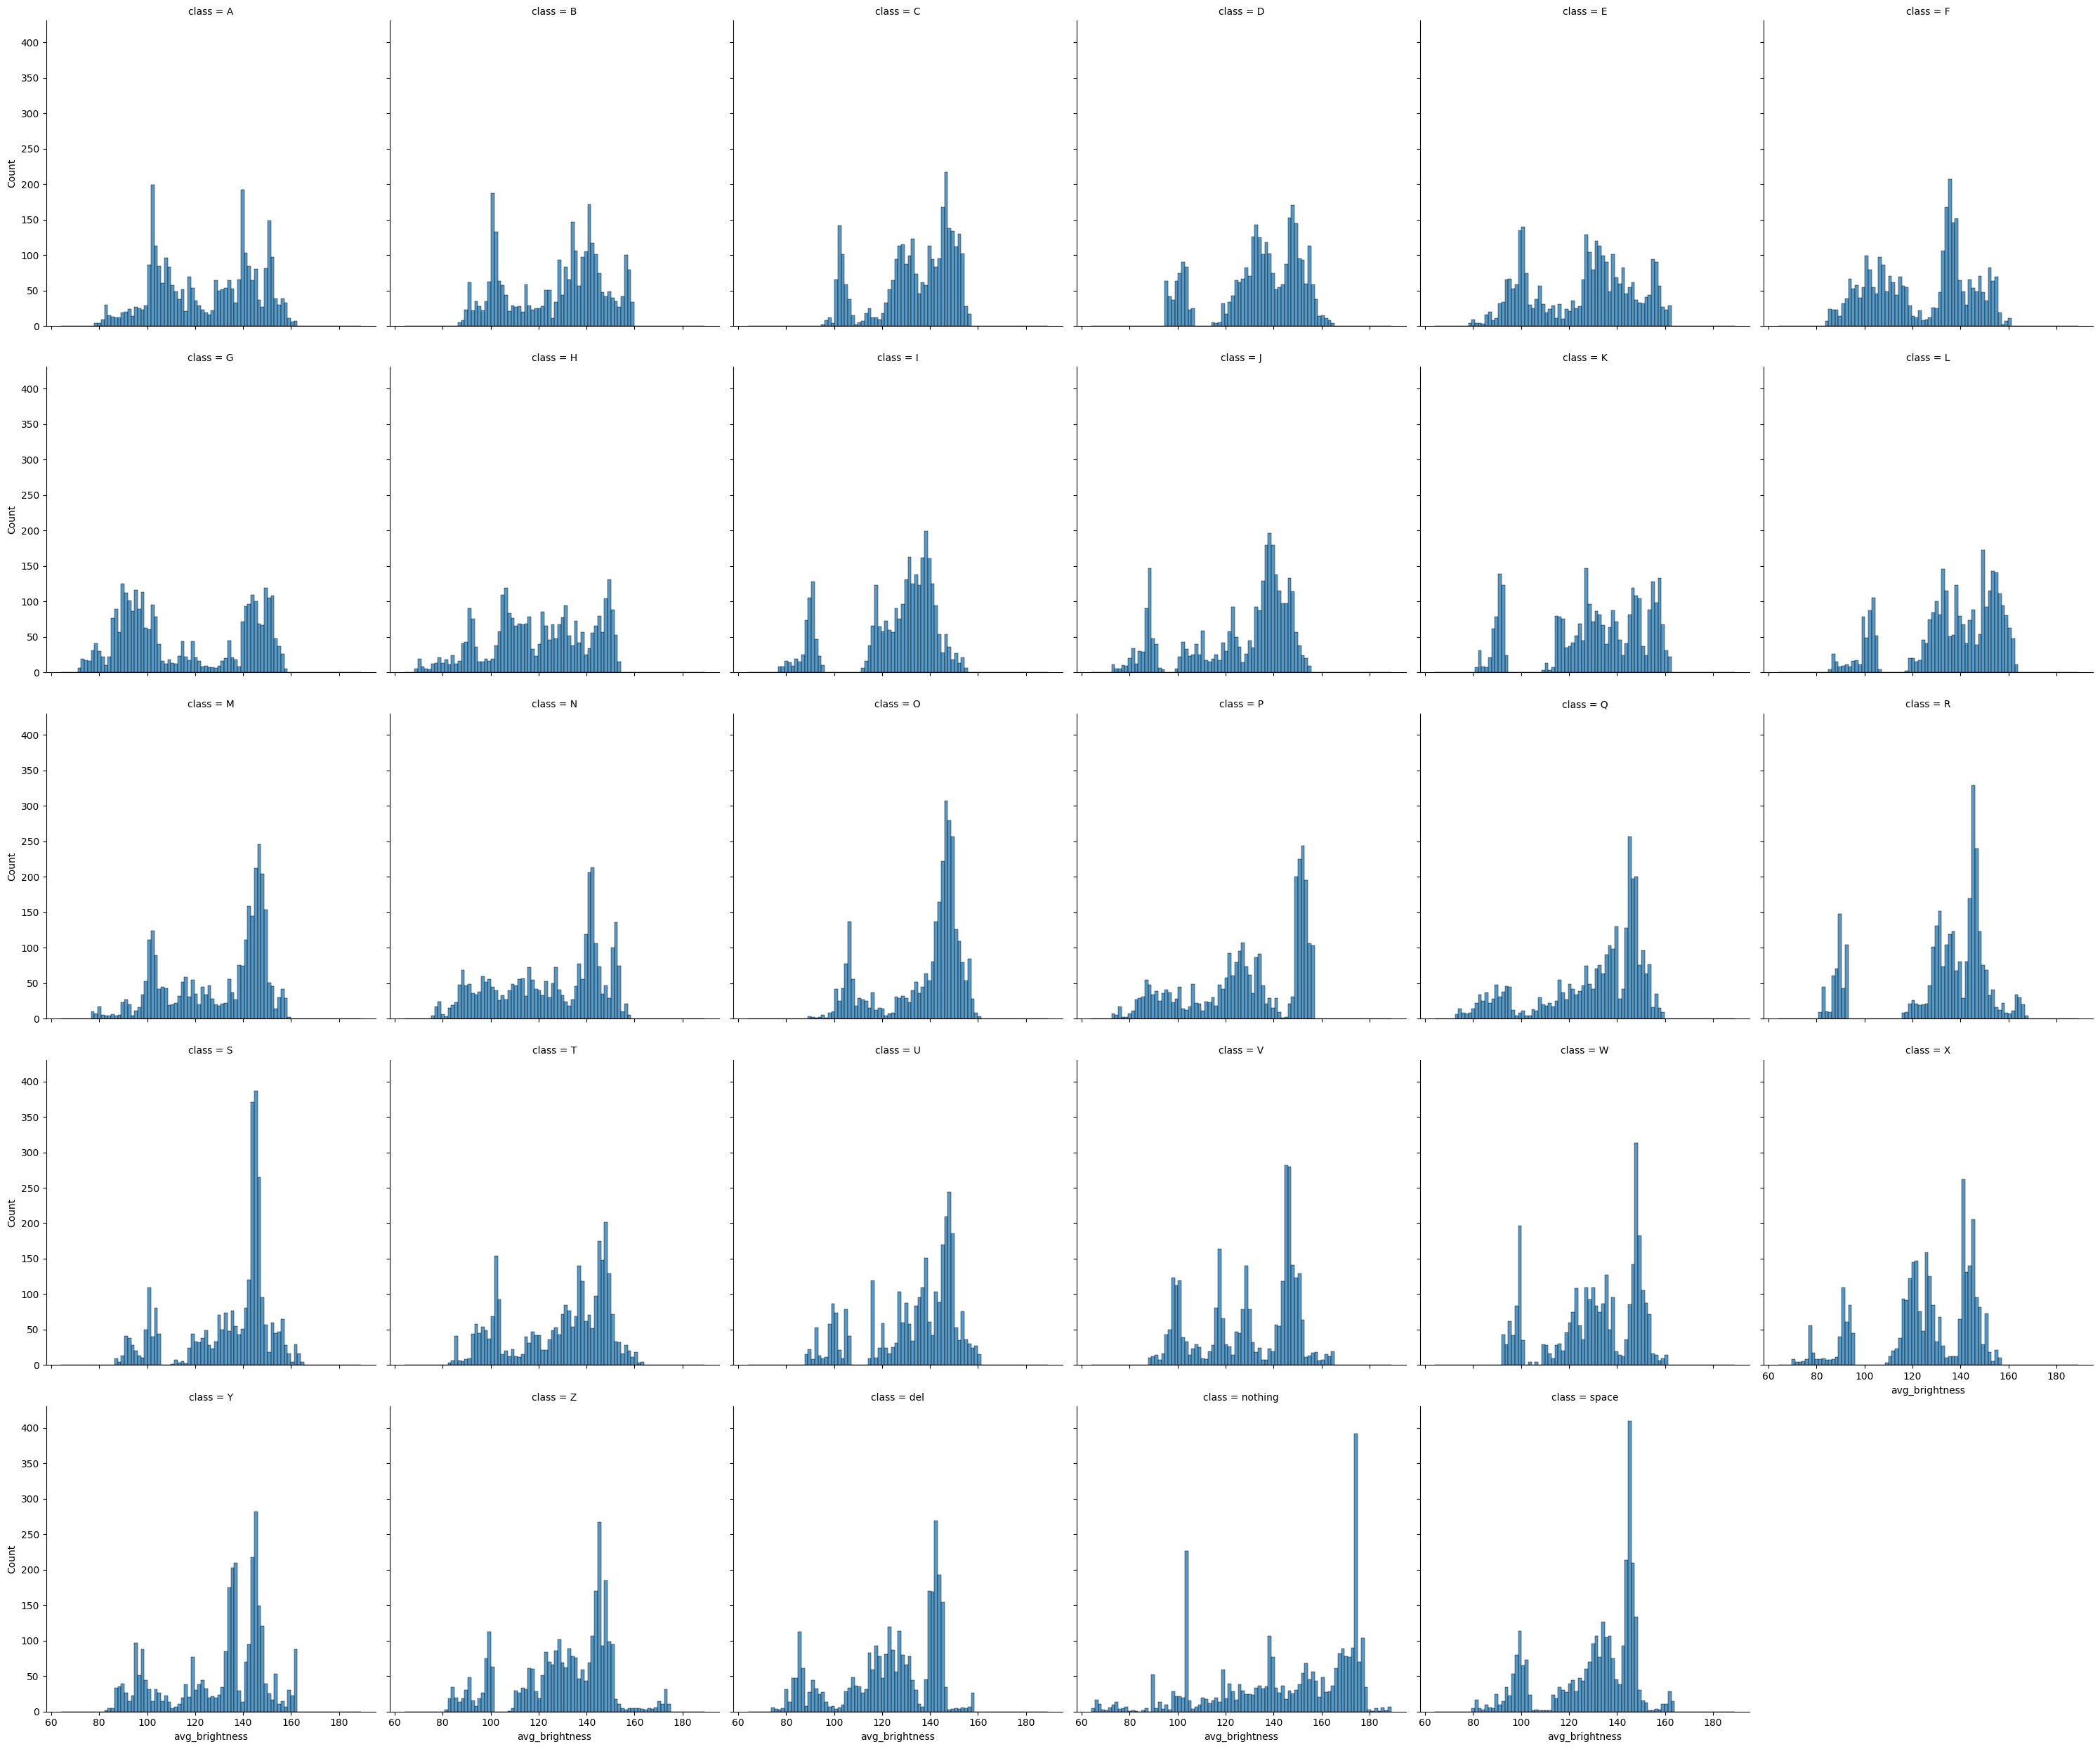

In [49]:
import seaborn as sns
sns.displot(data=train_df, col='class', col_wrap=6, x='avg_brightness')